In [1]:
import sys
from copy import deepcopy
sys.path.append("../") 

import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import LISA as l

import Wavelet as wv
import Glitch as gl
import Glitch_MCMC as glmc
import MCMC_tools as mct
import TDI as td


# constants
mHz = 1.0e-3
Hour = 3600.
Week = 7*24*Hour

In [2]:
Week = 3600.*24.*7.
dt   = 15.
Tobs = 2**np.ceil(np.log2(Week/dt))*dt


orb = l.Orbit(Tobs, dt=dt) # set up the LISA orbit
print("Nyquist Freq........ {} mHz".format(orb.f_ny*1000.))
print("Tobs................ {} days".format(Tobs/Week*7))

A    = 2.0e-20
f0   = 5.0*mHz
tau  = 1.5*Hour
t0   = 0.5*orb.Tobs
phi0 = 1.0
Q = 2*np.pi*f0*tau

print("tau................. {} s".format(tau))
print("Q................... {} s".format(Q))

comp_id = 6

paramsND = np.array([np.log(A), f0/mHz, t0/Week, tau/Week, phi0])
glitch = gl.Glitch(paramsND, orb, comp_id)

X_flag=None

glitch.calc_TDI()
glitch.calc_snr(X_flag)
glitch.adjust_snr(20, X_flag) # Adjust the SNR to desired target
print("Glitch SNR.......... {}".format(glitch.SNR))
glitch.calc_Fish(X_flag)

print()
e_vals, e_vecs = mct.get_Fisher_Eignen_BS(glitch.Fisher)
#print (e_vals)

modelX0 = glmc.Model(glitch, orb)
modelX0.get_loglkl(glitch.TDI, X_flag)
print()
print("modelX0 log L....... {}".format(modelX0.loglkl))

Nyquist Freq........ 33.333333333333336 mHz
Tobs................ 11.377777777777778 days
tau................. 5400.0 s
Q................... 169.64600329384885 s
Glitch SNR.......... 19.999999999999996


modelX0 log L....... 199.99999999999997


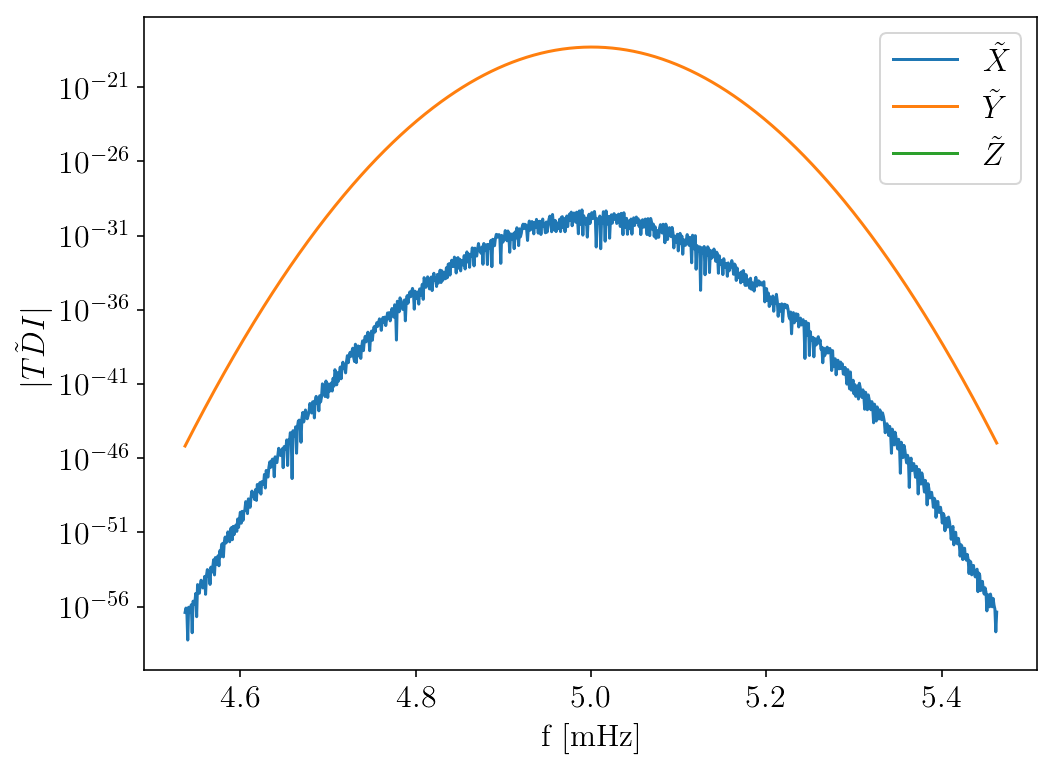

In [3]:
fig, ax = plt.subplots(1, figsize=(8,6))

ax.set_xlabel(r'f [mHz]', fontsize=16)
ax.set_ylabel(r'$|\tilde{TDI}|$', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=16)

f = glitch.TDI.freqs*1000

XX = np.abs(glitch.TDI.X)
YY = np.abs(glitch.TDI.Y)
ZZ = np.abs(glitch.TDI.Z)

ax.semilogy(f, XX, label=r'$\tilde{X}$')
ax.semilogy(f, YY, label=r'$\tilde{Y}$')
ax.semilogy(f, ZZ, label=r'$\tilde{Z}$')
    
ax.legend(loc='upper right', fontsize=16)
plt.show()

In [4]:
wrong_flag = 0
if (wrong_flag):
    comp_id_WRONG = 2

    paramsND_WRONG = np.array([np.log(A), f0/mHz, t0/Week, tau/Week, phi0])
    glitch_WRONG = gl.Glitch(paramsND_WRONG, orb, comp_id_WRONG)

    glitch_WRONG.calc_TDI()
    glitch_WRONG.calc_snr(X_flag)
    print(glitch_WRONG.SNR)
    glitch_WRONG.adjust_snr(20, X_flag) # Adjust the SNR to desired target
    TDI_data_wrong = deepcopy(glitch_WRONG.TDI)

    modelX0 = glmc.Model(glitch, orb)
    modelX0.get_loglkl(TDI_data_wrong, X_flag)

    print(np.sum(td.get_TDI_overlap(TDI_data_wrong, modelX0.Glitch.TDI, modelX0.Glitch.TDI.f_min, modelX0.Glitch.TDI.f_max, X_flag)/modelX0.Glitch.SNR/glitch_WRONG.SNR))

In [4]:
comp_switch = 1
PT = 1
X = X_flag

flag = glmc.Flag(comp_switch, PT, X)

TDI_data = deepcopy(glitch.TDI) # the data

N = 1*10**4
Burn = 1*10**4
lkl, chain, comp_id_ls, max_model = glmc.MCMC_glitch(TDI_data, orb, modelX0, seed=1, N=N, Burn=Burn, Flag=flag)
#lkl, chain, comp_id_ls, max_model = glmc.MCMC_glitch(TDI_data_wrong, orb, modelX0, seed=1, N=N, Burn=Burn, Flag=flag)

print(max_model.Glitch.comp_id)
FF = (max_model.loglkl + 0.5*max_model.Glitch.SNR**2)/max_model.Glitch.SNR/modelX0.Glitch.SNR
print("FF......... {}".format(FF))

100%|██████████| 20000/20000 [03:26<00:00, 96.65it/s]

Temperature Ladder...... [ 1.          1.20302504  1.44726924  1.74110113  2.09458825  2.5198421
  3.03143313  3.64688995  4.38729992  5.27803164  6.34960421  7.63873283
  9.18958684 11.05530304 13.29980634 16.        ]
acceptance rate......... [ 5.0845781   5.11425462  4.70867544  5.09447027  5.49015729  5.94519735
  6.52883569  7.5279454   8.47759422  9.88228311 11.26718765 11.56395291
 12.20694431 14.27440894 18.75556435 38.70808191]%
swap acceptance rate.... [82.28043143 82.53968254 80.87591241 85.31810767 81.26934985 79.87711214
 82.81938326 78.85196375 80.92105263 79.78723404 84.59459459 84.97109827
 77.93650794 68.85496183 45.29667149]%
max logL................ 199.99999999999997
6
FF......... 1.0


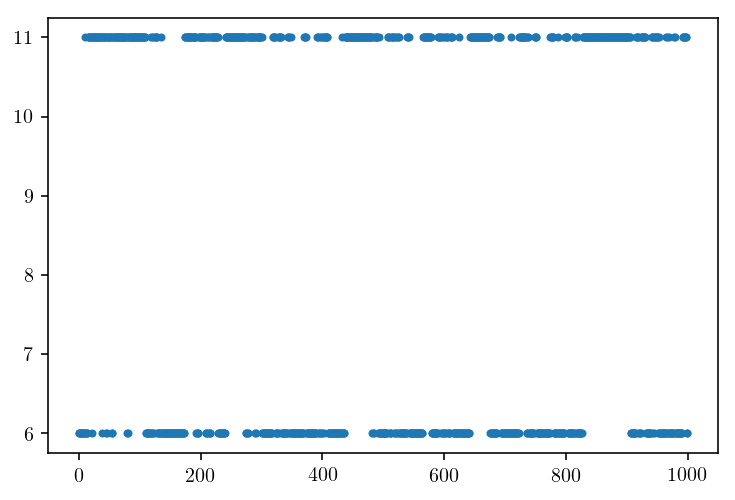

0.949317738791423


In [5]:
plt.plot(comp_id_ls[:,0],'.')
plt.show()

mask_true = (comp_id_ls[:,comp_id]==comp_id)
N_true = len(comp_id_ls[mask_true,0])
BF = N_true/(len(comp_id_ls)-N_true)
print(BF)


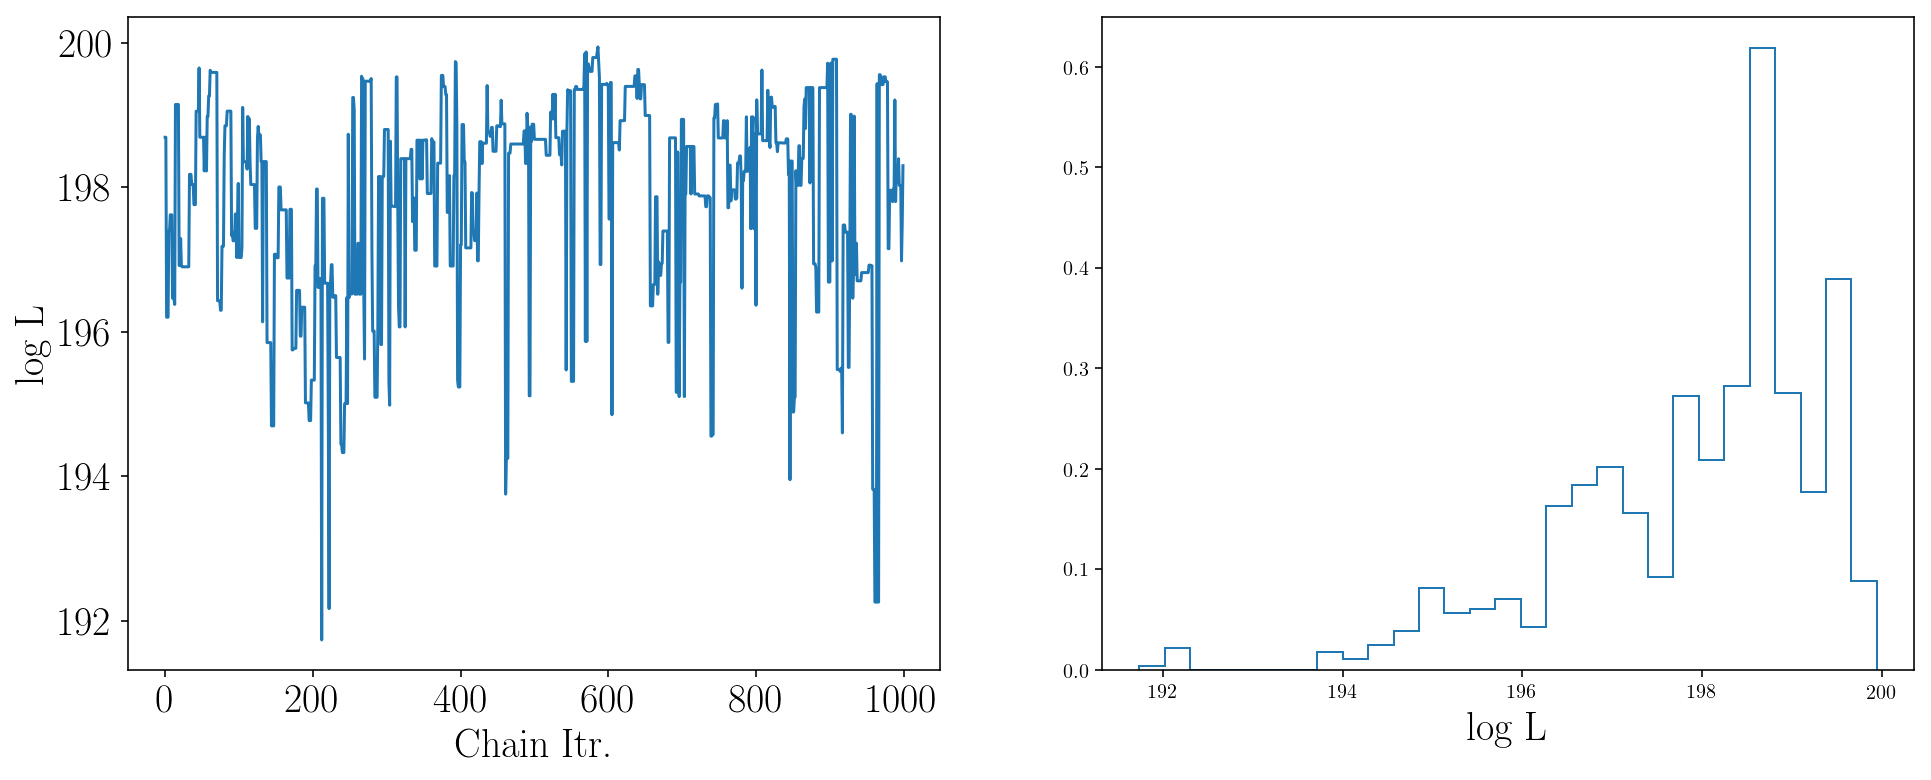

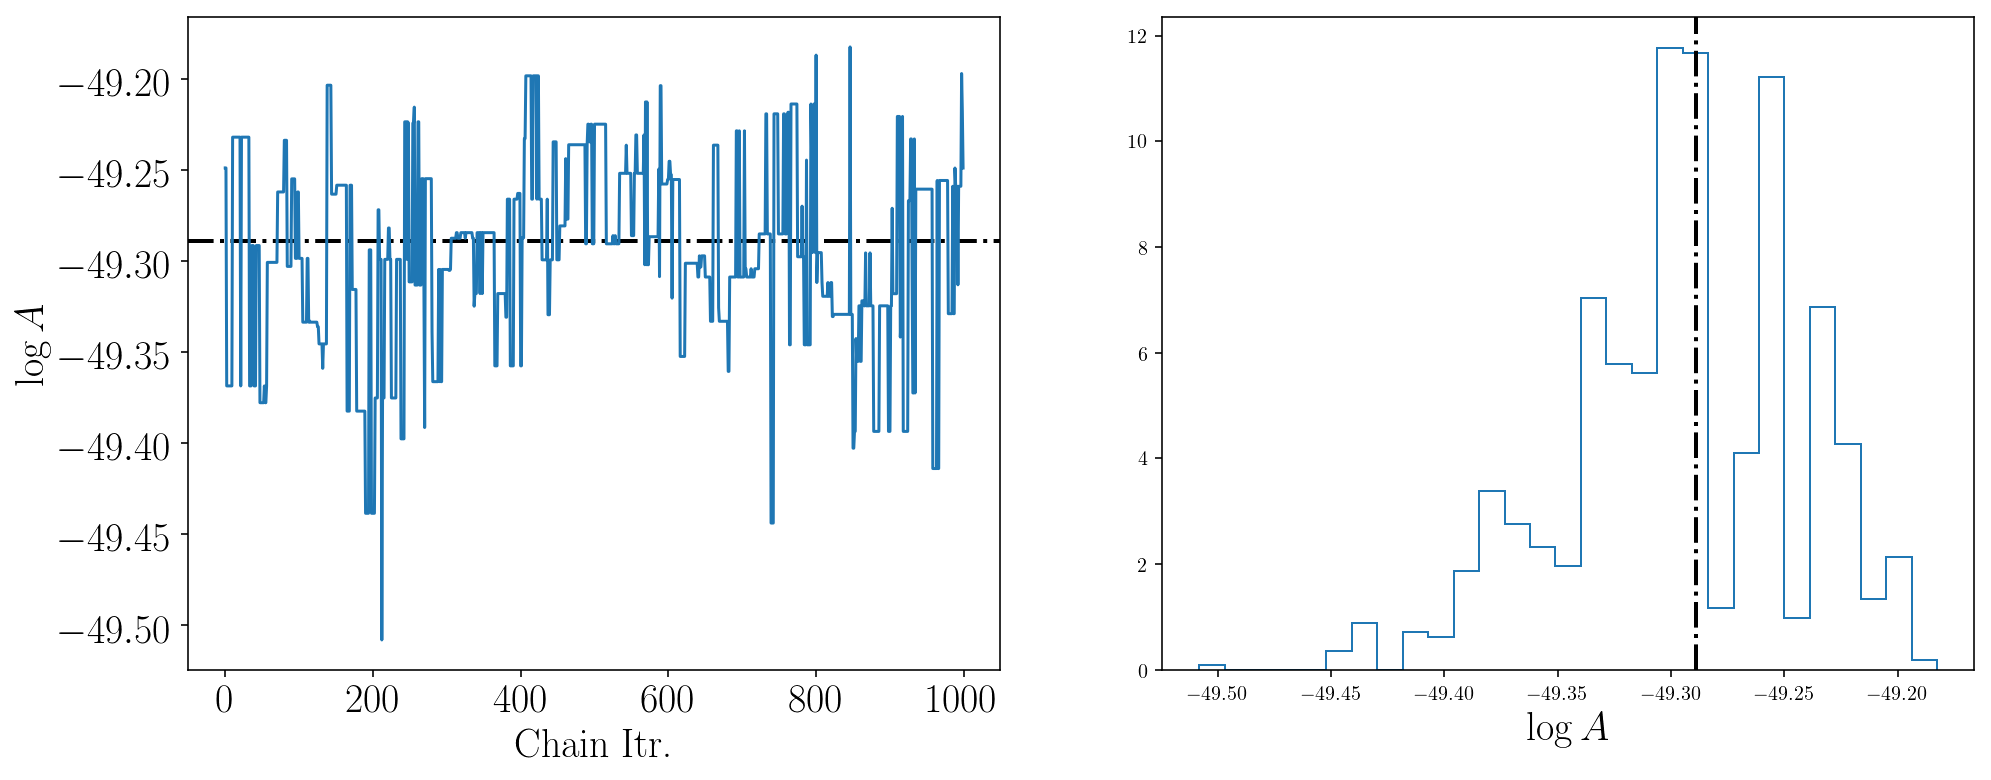

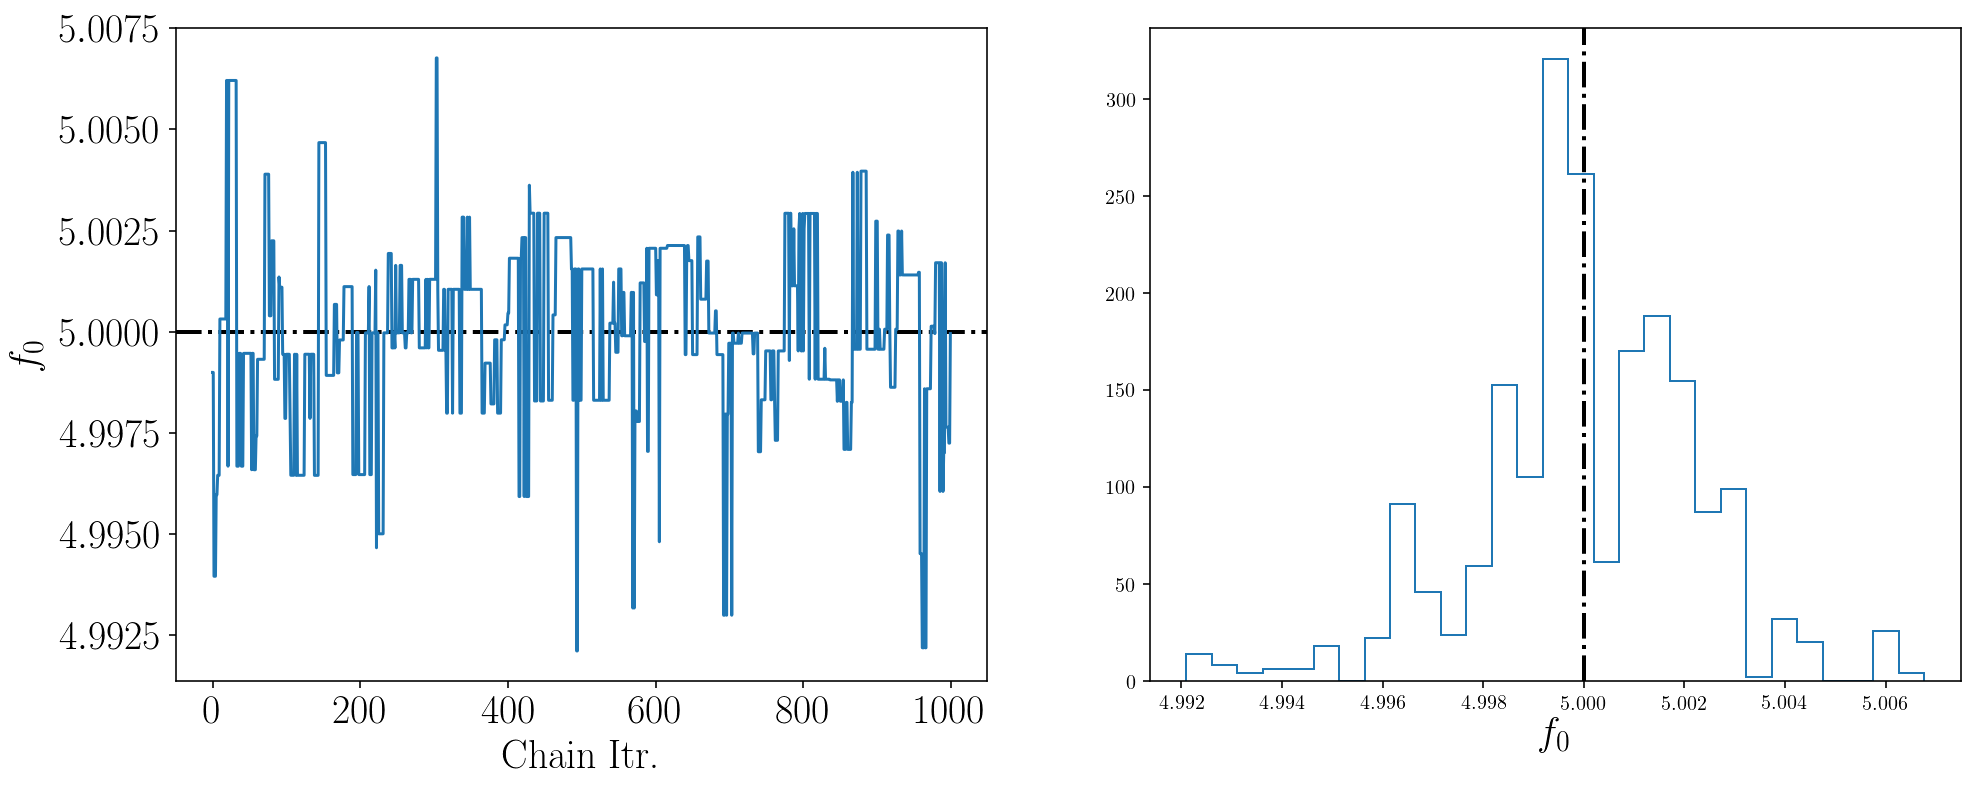

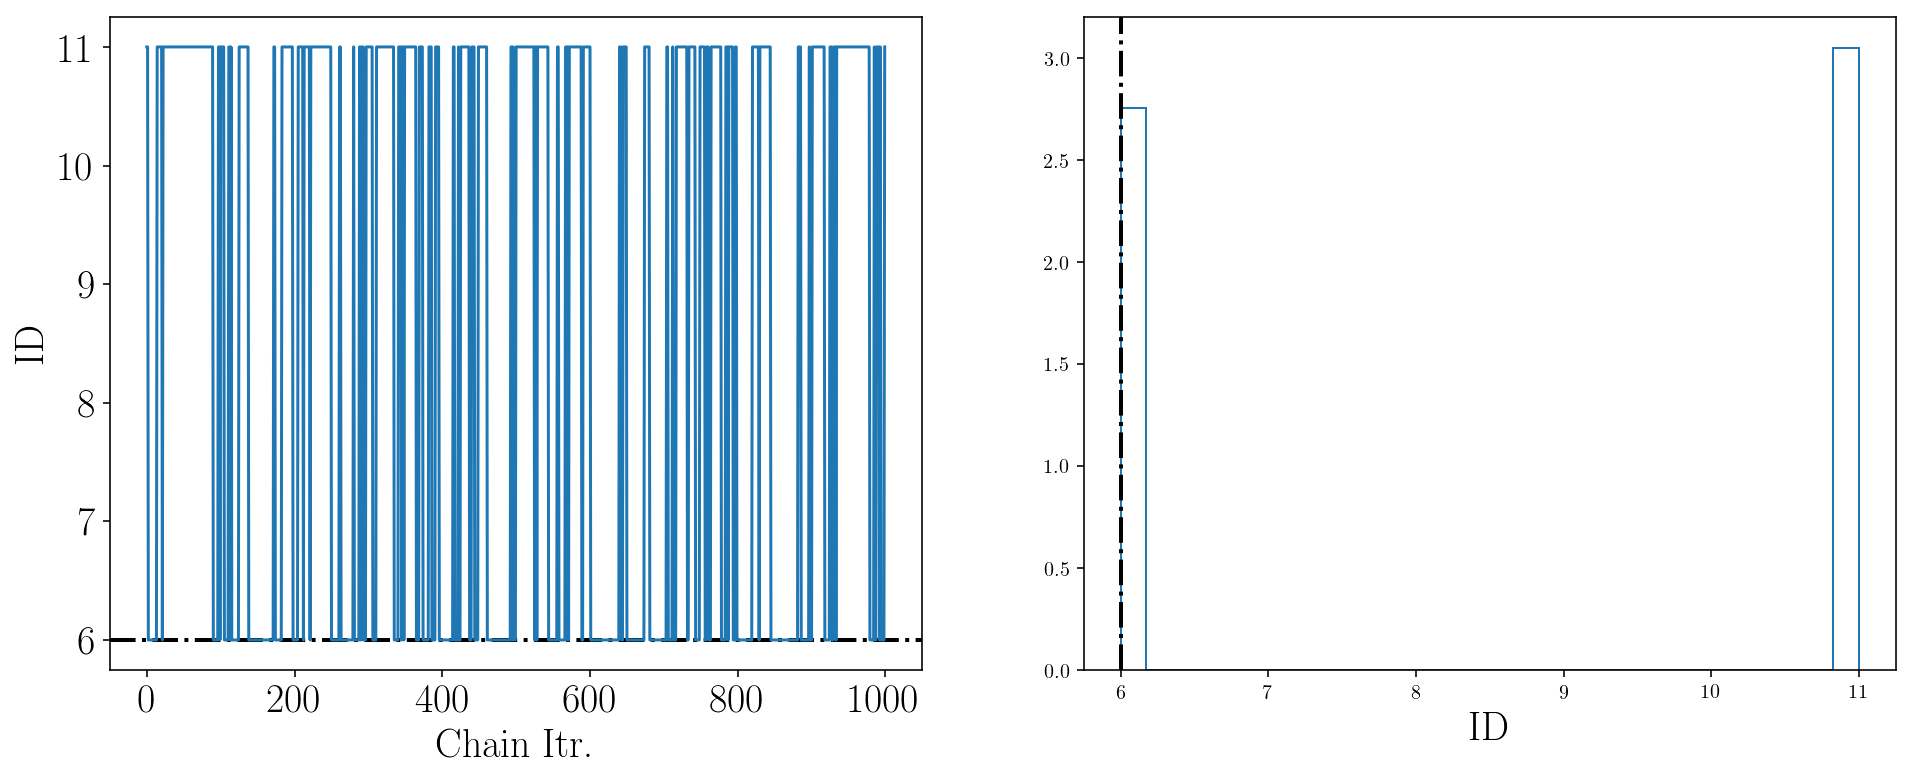

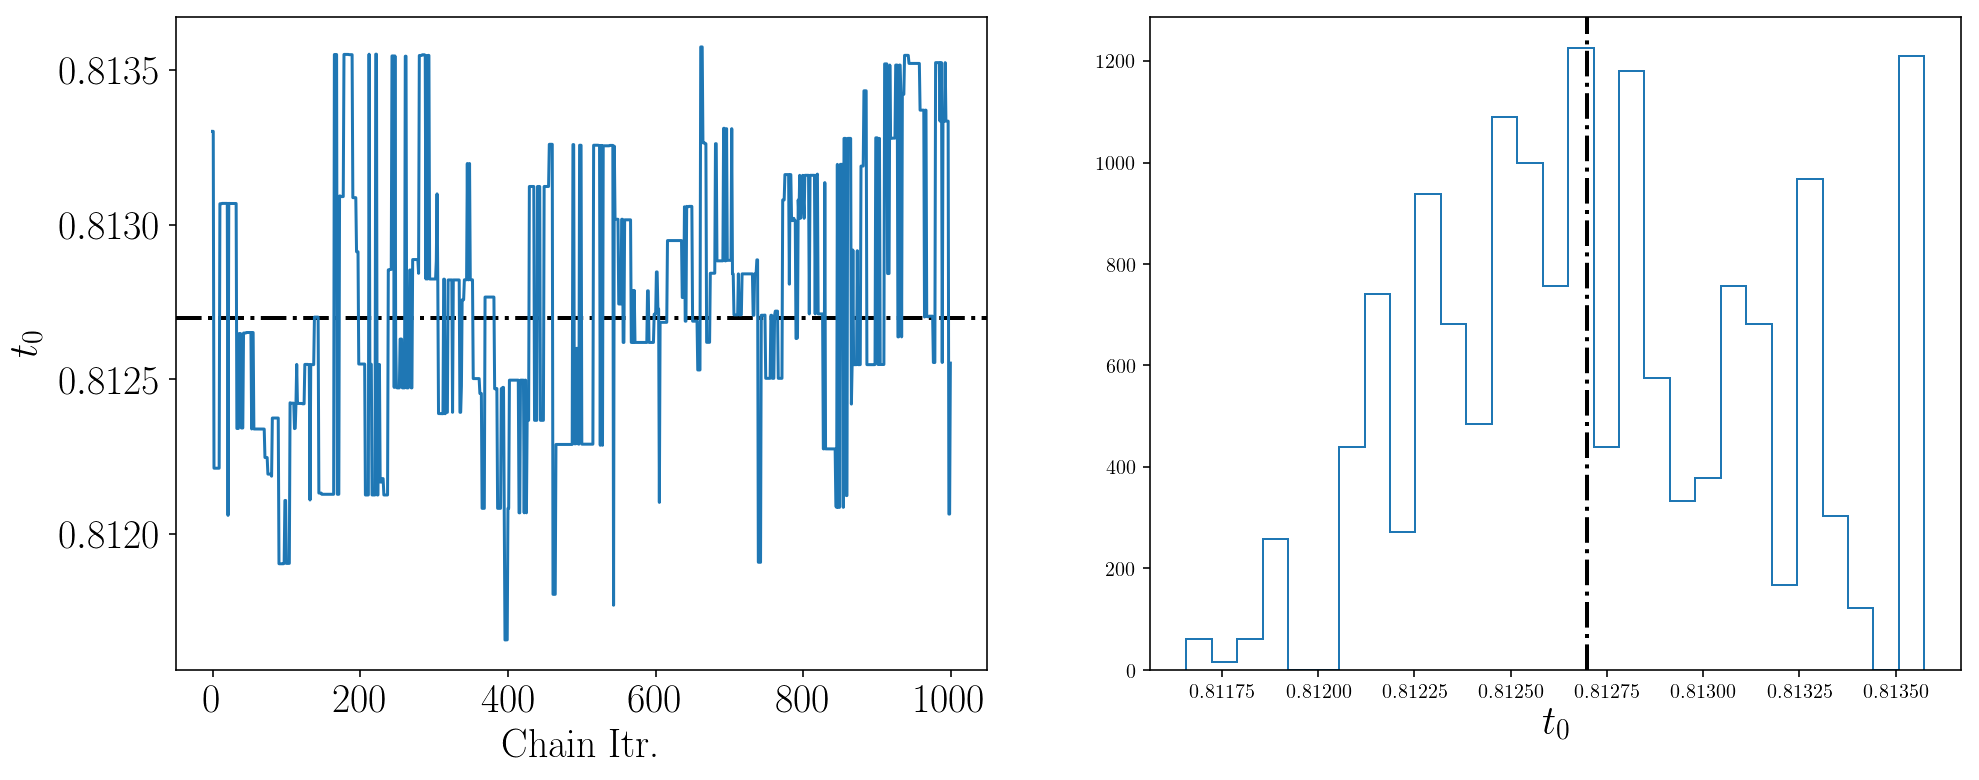

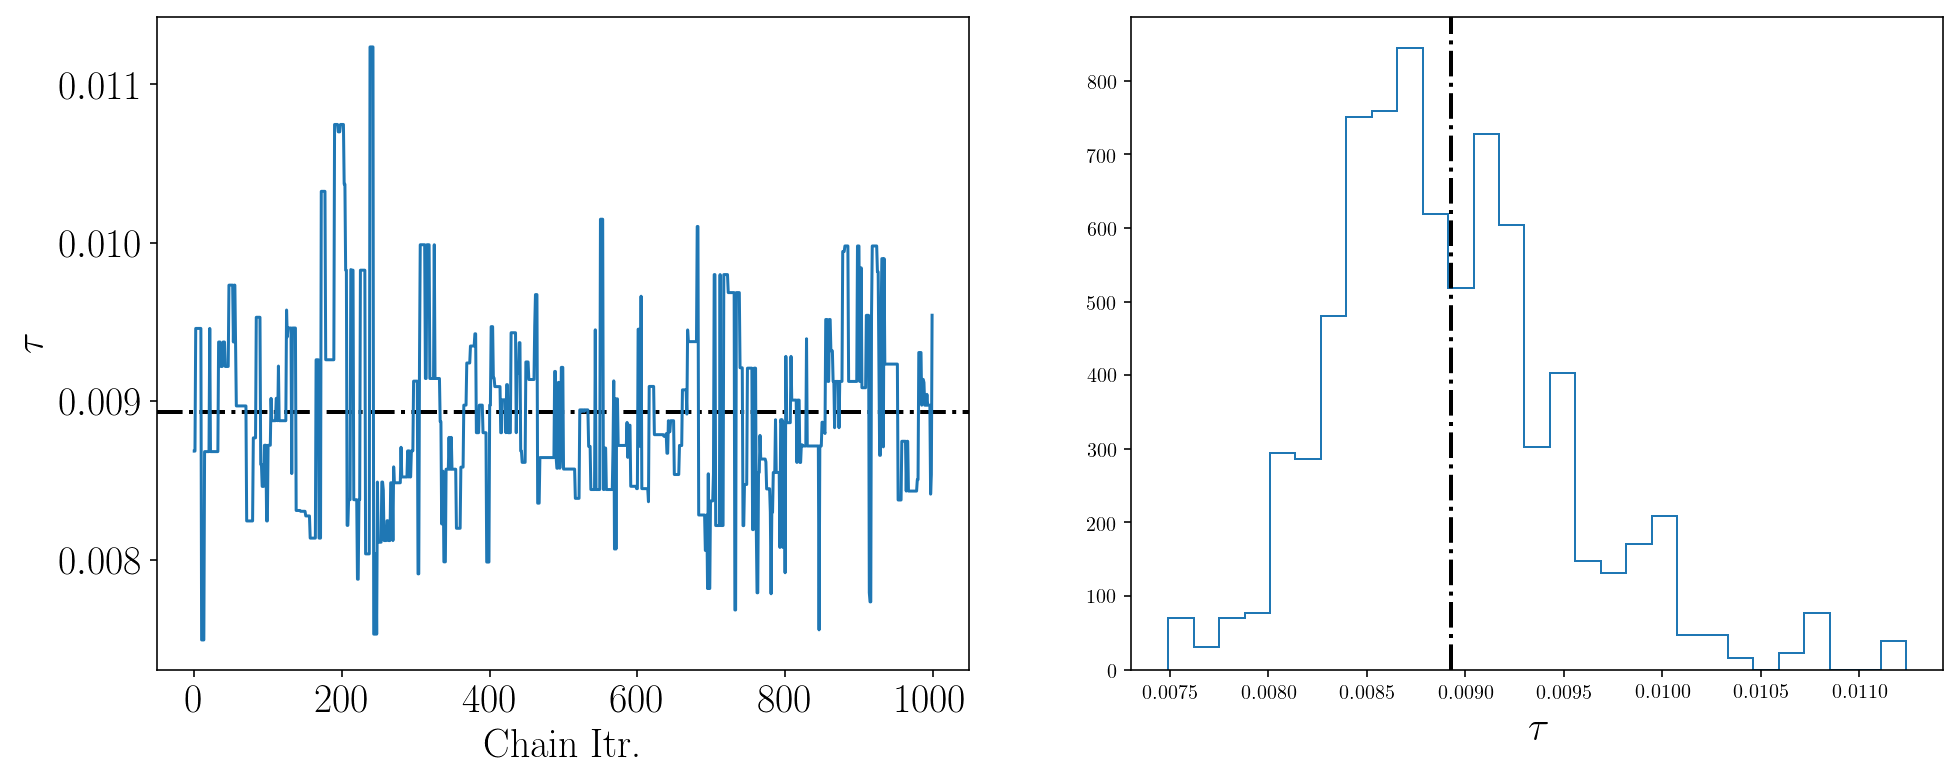

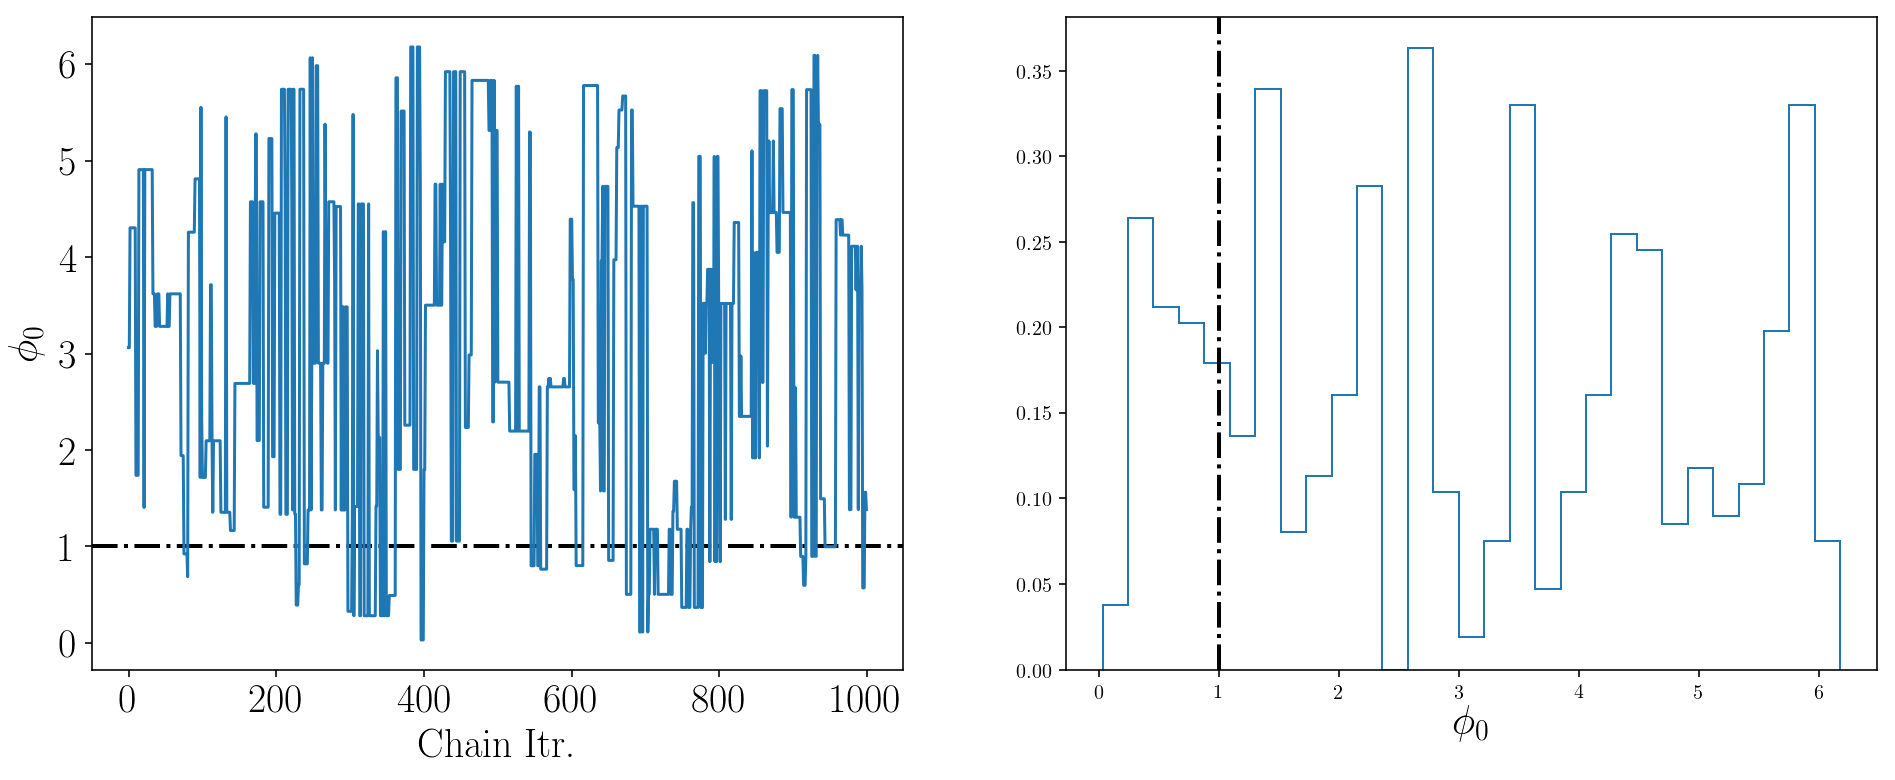

In [9]:
n_bins = 30
mct.plot_chain(lkl[:,0], r'log L', n_bins)
mct.plot_chain(chain[0,:,0], r'$\log A$',   n_bins, np.log(glitch.Wavelet.A))
mct.plot_chain(chain[1,:,0], r'$f_{0}$',    n_bins, glitch.Wavelet.f0/mHz)
mct.plot_chain(comp_id_ls[:,0], r'ID',    n_bins, comp_id)

mct.plot_chain(chain[2,:,0], r'$t_{0}$',    n_bins, glitch.Wavelet.t0/Week)
mct.plot_chain(chain[3,:,0], r'$\tau$',     n_bins, glitch.Wavelet.tau/Week)
mct.plot_chain(chain[4,:,0], r'$\phi_{0}$', n_bins, glitch.Wavelet.phi0)


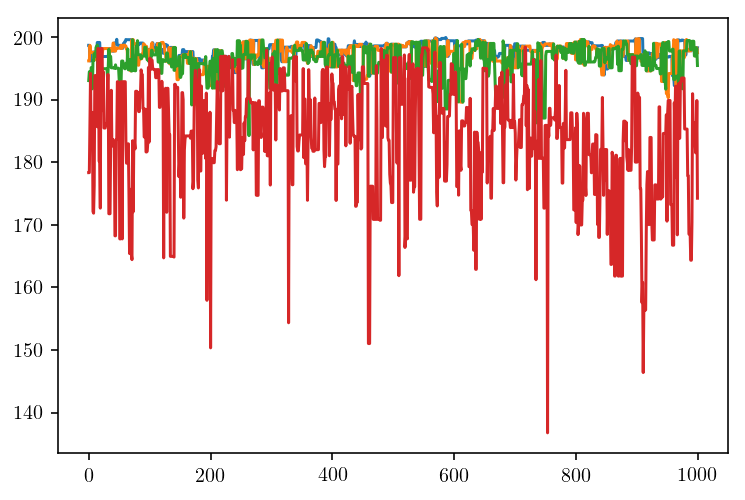

In [11]:
plt.plot(lkl[:,0])
plt.plot(lkl[:,1])
plt.plot(lkl[:,2])
plt.plot(lkl[:,9])
#plt.plot(lkl[:,4])
plt.show()


In [10]:
print(mct.get_autocorr_length(chain[0,:,0]))
print(mct.get_autocorr_length(chain[1,:,0]))
print(mct.get_autocorr_length(chain[2,:,0]))
print(mct.get_autocorr_length(chain[3,:,0]))
print(mct.get_autocorr_length(chain[4,:,0]))

47
41
97
20
30


In [6]:
np.geomspace(1,10,3)

array([ 1.        ,  3.16227766, 10.        ])

In [16]:
-1.1%np.pi

2.041592653589793

In [14]:
-1.1+2*np.pi

5.183185307179587

In [9]:
(2.0e-5/1.0e-1)**10

1.0240000000000006e-37

In [12]:
np.exp(0.2/100)

1.0020020013340003